## Imports

In [1]:
import warnings

# def fxn():
#     warnings.warn("deprecated", DeprecationWarning)

# with warnings.catch_warnings():
#     warnings.simplefilter("ignore")
#     fxn()
    
warnings.filterwarnings('ignore')

#warning website: https://queirozf.com/entries/suppressing-ignoring-warnings-in-python-reference-and-examples

In [2]:
import pandas as pd
import numpy as np
import re
import string
from pprint import pprint

import nltk
from nltk.corpus import stopwords
from nltk import word_tokenize, pos_tag
from nltk.stem import WordNetLemmatizer
from nltk.corpus import wordnet
nltk.download('wordnet')
nltk.download('stopwords')
from nltk.corpus import stopwords

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import NMF
from sklearn.feature_extraction import text
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import jaccard_score

import pyLDAvis
import pyLDAvis.gensim as gensimvis
import pyLDAvis.sklearn
import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt

import gensim
from gensim.utils import simple_preprocess
import gensim.corpora as corpora
from gensim.corpora import Dictionary
from gensim.models import LdaModel, CoherenceModel
from gensim.models.nmf import Nmf

import bitermplus as btm

import spacy
import operator
from operator import itemgetter
from itertools import combinations


[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/rachaellam/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/rachaellam/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
/opt/homebrew/lib/python3.9/site-packages/gensim/matutils.py:22: DeprecationWarning: Please use `triu` from the `scipy.linalg` namespace, the `scipy.linalg.special_matrices` namespace is deprecated.
  from scipy.linalg.special_matrices import triu
/opt/homebrew/lib/python3.9/site-packages/scipy/sparse/sparsetools.py:21: DeprecationWarning: `scipy.sparse.sparsetools` is deprecated!
scipy.sparse.sparsetools is a private module for scipy.sparse, and should not be used.
  _deprecated()


In [3]:
# Way around missing packages that for some reason I can't download the normal way

import os
import nltk

# Create NLTK data directory
NLTK_DATA_DIR = './nltk_data'
if not os.path.exists(NLTK_DATA_DIR):
        os.makedirs(NLTK_DATA_DIR)

nltk.data.path.append(NLTK_DATA_DIR)

# Download packages and store in directory above
nltk.download('punkt', download_dir=NLTK_DATA_DIR)
nltk.download('averaged_perceptron_tagger', download_dir=NLTK_DATA_DIR)
nltk.download('wordnet', download_dir=NLTK_DATA_DIR)

[nltk_data] Downloading package punkt to ./nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     ./nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package wordnet to ./nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

## Data Import

In [4]:
df = pd.read_csv("data/doj.csv")
df = df.drop(columns=['id','topics','components'], axis=1)

## Data Cleaning

In [5]:
df['contents'] = df['contents'].astype(str)
df['contents_processed'] = \
df['contents'].map(lambda x: re.sub('[,\.!?]','',x))
df['contents_processed'] = \
df['contents_processed'].map(lambda x: x.lower())
df['contents_processed']

df['title'] = df['title'].astype(str)
df['title_processed'] = \
df['title'].map(lambda x: re.sub('[,\.!?]','',x))
df['title_processed'] = \
df['title_processed'].map(lambda x: x.lower())
df['title_processed']

df = df.drop(columns=['title', 'contents'])
df

<>:3: DeprecationWarning: invalid escape sequence \.
<>:10: DeprecationWarning: invalid escape sequence \.
<>:3: DeprecationWarning: invalid escape sequence \.
<>:10: DeprecationWarning: invalid escape sequence \.
/var/folders/fm/xwcj8f4d2xl395kr3dnsf8z40000gn/T/ipykernel_59148/202145478.py:3: DeprecationWarning: invalid escape sequence \.
  df['contents'].map(lambda x: re.sub('[,\.!?]','',x))
/var/folders/fm/xwcj8f4d2xl395kr3dnsf8z40000gn/T/ipykernel_59148/202145478.py:10: DeprecationWarning: invalid escape sequence \.
  df['title'].map(lambda x: re.sub('[,\.!?]','',x))


,date,contents_processed,title_processed
0,2018-07-27,the us district court for the northern distric...,district court enters permanent injunction aga...
1,2018-07-27,the department of justice announced today that...,justice department announces resolution with ...
2,2018-07-27,yesterday a federal judge found ahmed el-sheri...,kansas city area laboratory owner convicted of...
3,2018-07-26,the department of justice announced today that...,3m company agrees to pay $91 million to resolv...
4,2018-07-26,a federal grand jury in new orleans louisiana ...,amite residents charged with civil rights crim...
...,...,...,...
17819,2018-07-30,washington – a jordanian national residing in ...,jordanian national arrested in new york to fac...
17820,2018-07-30,a charlottesville virginia man was sentenced t...,former virginia high school science teacher se...
17821,2018-07-30,a federal jury convicted a sterling virginia w...,former owner of sleep study businesses convict...
17822,2018-07-30,remarks as prepared for delivery\r\nthank you ...,attorney general sessions delivers remarks at ...


In [6]:
contents = df.drop(['title_processed'], axis=1)
titles = df.drop(['contents_processed'], axis=1)

## Tokenization / Lemmatization / Stop Word Removal

Lemmatizing contents_processed on both contents and titles dataframes

In [7]:
nlp = spacy.load('en_core_web_sm', disable=['parser', 'ner'])

def lemmatize(data):
    doc = nlp(data)
    return " ".join([token.lemma_ for token in doc])

In [8]:
#contents['lemma'] = contents['contents_processed'].apply(lemmatize)
titles['lemma'] = titles['title_processed'].apply(lemmatize)

Creating tokens of the lemmatized words

In [9]:
stop_words = stopwords.words('english')
stop_words.extend(['department', 'sentenced', 'justice', 'man', 'attorney', 'district', 'law', 'case', 'general',
                  'assistant', 'office', 'law', 'division', 'us', 'yesterday', 'today', 'enforcement', 'united',
                  'states', 'also', 'say', 'one', 'criminal', 'court', 'defendant', 'year', 'act', 'use'])

def sent_to_words(sentences):
    for sentence in sentences:
        # deacc=True removes punctuations
        yield(gensim.utils.simple_preprocess(str(sentence), deacc=True))
        
def remove_stopwords(texts):
    return [[word for word in simple_preprocess(str(doc)) 
             if word not in stop_words] for doc in texts]

In [10]:
data_title = titles.lemma.values.tolist()
title_words = list(sent_to_words(data_title))
title_words = remove_stopwords(title_words)

In [11]:
titles['tokens'] = title_words

In [12]:
titles

,date,title_processed,lemma,tokens
0,2018-07-27,district court enters permanent injunction aga...,district court enter permanent injunction agai...,"[enter, permanent, injunction, chicago, compan..."
1,2018-07-27,justice department announces resolution with ...,justice department announce resolution with ...,"[announce, resolution, swiss, financial, asset..."
2,2018-07-27,kansas city area laboratory owner convicted of...,kansas city area laboratory owner convict of i...,"[kansas, city, area, laboratory, owner, convic..."
3,2018-07-26,3m company agrees to pay $91 million to resolv...,3 m company agree to pay $ 91 million to resol...,"[company, agree, pay, million, resolve, allega..."
4,2018-07-26,amite residents charged with civil rights crim...,amite resident charge with civil right crime ...,"[amite, resident, charge, civil, right, crime,..."
...,...,...,...,...
17819,2018-07-30,jordanian national arrested in new york to fac...,jordanian national arrest in new york to face ...,"[jordanian, national, arrest, new, york, face,..."
17820,2018-07-30,former virginia high school science teacher se...,former virginia high school science teacher se...,"[former, virginia, high, school, science, teac..."
17821,2018-07-30,former owner of sleep study businesses convict...,former owner of sleep study business convict o...,"[former, owner, sleep, study, business, convic..."
17822,2018-07-30,attorney general sessions delivers remarks at ...,attorney general session deliver remark at the...,"[session, deliver, remark, religious, liberty,..."


## Count Vectorizer

In [242]:
#vectorizer = CountVectorizer(max_df = 0.7)
vectorizer = TfidfVectorizer(stop_words=stop_words, ngram_range = (1,1), max_df = 0.90, min_df=0.005)
vectorizer.fit_transform(titles.lemma)
vector_vocab = vectorizer.get_feature_names()

In [243]:
vector_vocab

['10',
 '12',
 '13',
 '15',
 '19',
 '20',
 '25',
 '30',
 'abuse',
 'access',
 'account',
 'acquisition',
 'action',
 'address',
 'admit',
 'afghanistan',
 'agency',
 'agent',
 'agree',
 'agreement',
 'air',
 'alabama',
 'allegation',
 'allege',
 'alleged',
 'allegedly',
 'american',
 'angeles',
 'announce',
 'annual',
 'antitrust',
 'area',
 'arizona',
 'army',
 'arrest',
 'assault',
 'assistant',
 'associate',
 'attack',
 'attempt',
 'attorney',
 'auction',
 'award',
 'bank',
 'bar',
 'barr',
 'base',
 'bid',
 'billion',
 'bribe',
 'bribery',
 'business',
 'businessman',
 'california',
 'campaign',
 'car',
 'care',
 'carolina',
 'case',
 'center',
 'ceo',
 'charge',
 'chicago',
 'chief',
 'child',
 'chinese',
 'citizen',
 'city',
 'civil',
 'claim',
 'clean',
 'clinic',
 'co',
 'colorado',
 'combat',
 'commission',
 'commit',
 'community',
 'company',
 'complaint',
 'computer',
 'conference',
 'connection',
 'conspiracy',
 'conspire',
 'contract',
 'contractor',
 'control',
 'convict'

In [237]:
def MIN_DF(texts):
    return [word for word in texts 
            if word in vector_vocab.keys()]

def TFIDF_MIN_DF(texts):
    return [word for word in texts 
            if word in vector_vocab]

stop_words = stopwords.words('english')
stop_words.extend(['also', 'say', 'one', 'criminal', 'court', 'defendant', 'year', 'act', 'use'])

def remove_stopwords_2(texts):
    return [word for word in texts
           if word not in stop_words]

In [244]:
titles['max_df'] = titles['tokens'].apply(TFIDF_MIN_DF)

In [245]:
titles

,date,title_processed,lemma,tokens,max_df
0,2018-07-27,district court enters permanent injunction aga...,district court enter permanent injunction agai...,"[enter, permanent, injunction, chicago, compan...","[enter, injunction, chicago, company, stop, di..."
1,2018-07-27,justice department announces resolution with ...,justice department announce resolution with ...,"[announce, resolution, swiss, financial, asset...","[announce, swiss, financial, firm]"
2,2018-07-27,kansas city area laboratory owner convicted of...,kansas city area laboratory owner convict of i...,"[kansas, city, area, laboratory, owner, convic...","[kansas, city, area, owner, convict, illegally]"
3,2018-07-26,3m company agrees to pay $91 million to resolv...,3 m company agree to pay $ 91 million to resol...,"[company, agree, pay, million, resolve, allega...","[company, agree, pay, million, resolve, allega..."
4,2018-07-26,amite residents charged with civil rights crim...,amite resident charge with civil right crime ...,"[amite, resident, charge, civil, right, crime,...","[resident, charge, civil, right, crime, abuse,..."
...,...,...,...,...,...
17819,2018-07-30,jordanian national arrested in new york to fac...,jordanian national arrest in new york to face ...,"[jordanian, national, arrest, new, york, face,...","[national, arrest, new, york, charge, conspiracy]"
17820,2018-07-30,former virginia high school science teacher se...,former virginia high school science teacher se...,"[former, virginia, high, school, science, teac...","[former, virginia, school, sentence, prison, c..."
17821,2018-07-30,former owner of sleep study businesses convict...,former owner of sleep study business convict o...,"[former, owner, sleep, study, business, convic...","[former, owner, business, convict, fraud, cons..."
17822,2018-07-30,attorney general sessions delivers remarks at ...,attorney general session deliver remark at the...,"[session, deliver, remark, religious, liberty,...","[session, deliver, remark]"


## LDA Modelling

LDA modelling on titles. Might be too small...

In [281]:
title_words = list(titles['tokens'])

In [247]:
# Create Dictionary
id2word_title = corpora.Dictionary(title_words)
# Create Corpus
texts_title = title_words
# Term Document Frequency
corpus_title = [id2word_title.doc2bow(text) for text in texts_title]

In [248]:
num_topics = list(np.arange(2, 15, 1))
LDA_models = {}
for num in range(0, len(num_topics)):
    LDA_models[num] = gensim.models.LdaMulticore(corpus=corpus_title, id2word=id2word_title, 
                                                 num_topics=num_topics[num])

In [249]:
LDA_topics = {}
for num in range(0, len(num_topics)):
    LDA_topics[num] = LDA_models[num].print_topics()

In [250]:
pprint(LDA_topics)

{0: [(0,
      '0.041*"guilty" + 0.040*"plead" + 0.028*"fraud" + 0.028*"sentence" + '
      '0.026*"tax" + 0.022*"scheme" + 0.021*"charge" + 0.020*"former" + '
      '0.020*"prison" + 0.015*"conspiracy"'),
     (1,
      '0.031*"sentence" + 0.030*"million" + 0.020*"prison" + 0.018*"pay" + '
      '0.018*"federal" + 0.017*"charge" + 0.017*"scheme" + 0.016*"fraud" + '
      '0.015*"tax" + 0.014*"former"')],
 1: [(0,
      '0.046*"sentence" + 0.037*"prison" + 0.033*"tax" + 0.022*"scheme" + '
      '0.021*"return" + 0.020*"fraud" + 0.019*"former" + 0.016*"million" + '
      '0.015*"guilty" + 0.014*"plead"'),
     (1,
      '0.033*"fraud" + 0.031*"million" + 0.031*"sentence" + 0.025*"scheme" + '
      '0.024*"guilty" + 0.024*"charge" + 0.021*"plead" + 0.017*"pay" + '
      '0.016*"prison" + 0.014*"former"'),
     (2,
      '0.055*"guilty" + 0.055*"plead" + 0.022*"former" + 0.020*"charge" + '
      '0.020*"tax" + 0.017*"statement" + 0.014*"federal" + 0.012*"two" + '
      '0.012*"million" + 

In [251]:
LDA_coherence_scores = {}
for num in range(0, len(num_topics)):
    LDA_coherence_scores[num] = [CoherenceModel(model=LDA_models[num],
                         texts=title_words,
                         dictionary=id2word_title,
                         coherence='c_v').get_coherence()]

In [252]:
LDA_coherence_scores_av = [np.array(list).mean() for list in [scores for scores in LDA_coherence_scores.values()]]

In [253]:
def jaccard_similarity(topic_1, topic_2):
    intersection = set(topic_1).intersection(set(topic_2))
    union = set(topic_1).union(set(topic_2))
    return float(len(intersection))/float(len(union))

In [254]:
LDA_jaccard_scores = []
for i in [*range(0,len(num_topics))]:
    jaccards = []
    for j in list(combinations([*range(0,len(LDA_topics[i]))],2)):
        t1 = LDA_topics[i][j[0]]
        t2 = LDA_topics[i][j[1]]
        jaccards.append(jaccard_similarity(set(re.sub("[^A-Za-z ]", "", t1[1]).split("  ")), 
                                           set(re.sub("[^A-Za-z ]", "", t2[1]).split("  "))))
        mean = sum(jaccards)/len(jaccards)
    LDA_jaccard_scores.append(mean)

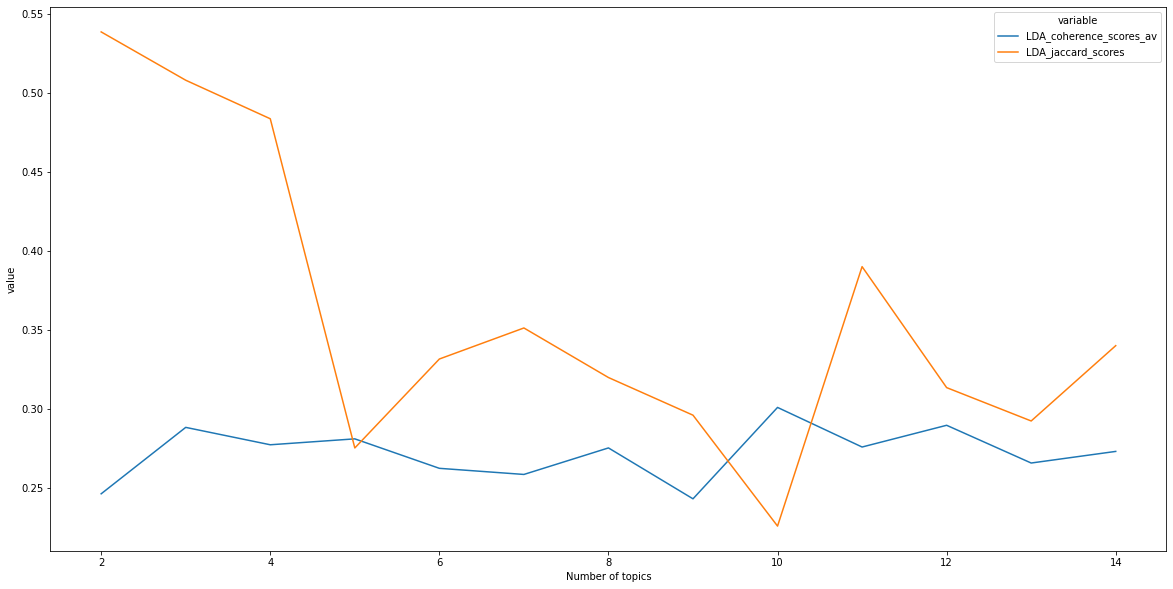

In [255]:
plt.figure(figsize=(20,10))
LDA = pd.DataFrame(list(zip(num_topics, LDA_coherence_scores_av, LDA_jaccard_scores)), 
                  columns = ['num_topics', 'LDA_coherence_scores_av', 'LDA_jaccard_scores'])
sns.lineplot(x = 'num_topics',
             y = 'value',
             hue = 'variable',
             data = pd.melt(LDA, ['num_topics']))
plt.xlabel('Number of topics')
plt.show()

In [256]:
lda_model = LDA_models[8]
lda_topics = lda_model.print_topics()
pprint(lda_topics)

[(0,
  '0.029*"file" + 0.019*"national" + 0.017*"million" + 0.017*"lawsuit" + '
  '0.017*"resolve" + 0.017*"announce" + 0.016*"discrimination" + '
  '0.016*"guilty" + 0.015*"relate" + 0.014*"former"'),
 (1,
  '0.042*"guilty" + 0.042*"plead" + 0.037*"sentence" + 0.027*"prison" + '
  '0.023*"fraud" + 0.022*"tax" + 0.020*"former" + 0.014*"national" + '
  '0.014*"return" + 0.013*"charge"'),
 (2,
  '0.045*"guilty" + 0.043*"plead" + 0.034*"million" + 0.033*"sentence" + '
  '0.027*"former" + 0.025*"prison" + 0.024*"pay" + 0.020*"agree" + 0.015*"two" '
  '+ 0.014*"charge"'),
 (3,
  '0.062*"sentence" + 0.055*"prison" + 0.031*"scheme" + 0.029*"former" + '
  '0.028*"fraud" + 0.022*"conspiracy" + 0.020*"million" + 0.016*"charge" + '
  '0.016*"guilty" + 0.016*"health"'),
 (4,
  '0.044*"guilty" + 0.043*"plead" + 0.036*"tax" + 0.034*"sentence" + '
  '0.024*"return" + 0.022*"scheme" + 0.021*"million" + 0.018*"former" + '
  '0.017*"prison" + 0.016*"false"'),
 (5,
  '0.043*"tax" + 0.041*"fraud" + 0.039*

In [257]:
LDAvis_prepared_nouns = pyLDAvis.gensim.prepare(lda_model, corpus_title, id2word_title)
pyLDAvis.display(LDAvis_prepared_nouns)

/opt/homebrew/lib/python3.9/site-packages/past/builtins/misc.py:45: DeprecationWarning: the imp module is deprecated in favour of importlib; see the module's documentation for alternative uses
  from imp import reload
/opt/homebrew/lib/python3.9/site-packages/past/builtins/misc.py:45: DeprecationWarning: the imp module is deprecated in favour of importlib; see the module's documentation for alternative uses
  from imp import reload
/opt/homebrew/lib/python3.9/site-packages/past/builtins/misc.py:45: DeprecationWarning: the imp module is deprecated in favour of importlib; see the module's documentation for alternative uses
  from imp import reload
/opt/homebrew/lib/python3.9/site-packages/past/builtins/misc.py:45: DeprecationWarning: the imp module is deprecated in favour of importlib; see the module's documentation for alternative uses
  from imp import reload
/opt/homebrew/lib/python3.9/site-packages/past/builtins/misc.py:45: DeprecationWarning: the imp module is deprecated in favour o

## NMF TFIDF

In [13]:
from pathlib import Path
import operator, joblib

In [14]:
snippets = titles['lemma'].tolist()

In [15]:
vectorizer = TfidfVectorizer(stop_words=stop_words, min_df = 0.003)
A = vectorizer.fit_transform(titles.lemma)
print( "Created %d X %d TF-IDF-normalized document-term matrix" % (A.shape[0], A.shape[1]) )

Created 17824 X 557 TF-IDF-normalized document-term matrix


In [16]:
terms =  list(vectorizer.get_feature_names_out())
print("Vocabulary has %d distinct terms" % len(terms))

Vocabulary has 557 distinct terms


In [17]:
joblib.dump((A,terms,snippets), "data/titles-tfidf.pkl") 

['data/titles-tfidf.pkl']

In [18]:
(A,terms,snippets) = joblib.load("data/titles-tfidf.pkl")
print( "Loaded %d X %d document-term matrix" % (A.shape[0], A.shape[1]) )

Loaded 17824 X 557 document-term matrix


In [19]:
kmin, kmax = 4, 20

In [20]:
topic_models = []
# try each value of k
for k in range(kmin,kmax+1):
    print("Applying NMF for k=%d ..." % k )
    # run NMF
    model = NMF( init="nndsvd", n_components=k ) 
    W = model.fit_transform( A )
    H = model.components_    
    # store for later
    topic_models.append( (k,W,H) )

Applying NMF for k=4 ...
Applying NMF for k=5 ...
Applying NMF for k=6 ...
Applying NMF for k=7 ...
Applying NMF for k=8 ...
Applying NMF for k=9 ...
Applying NMF for k=10 ...
Applying NMF for k=11 ...
Applying NMF for k=12 ...
Applying NMF for k=13 ...
Applying NMF for k=14 ...
Applying NMF for k=15 ...
Applying NMF for k=16 ...
Applying NMF for k=17 ...
Applying NMF for k=18 ...
Applying NMF for k=19 ...
Applying NMF for k=20 ...


In [21]:
titles['lemma_tokens'] = [word_tokenize(i) for i in titles['lemma']] 

w2v_model = gensim.models.Word2Vec(titles['lemma_tokens'], min_count=0.003, sg=1)

In [23]:
def calculate_coherence( w2v_model, term_rankings ):
    overall_coherence = 0.0
    for topic_index in range(len(term_rankings)):
        # check each pair of terms
        pair_scores = []
        for pair in combinations( term_rankings[topic_index], 2 ):
            pair_scores.append( w2v_model.wv.similarity(pair[0], pair[1]) )
        # get the mean for all pairs in this topic
        topic_score = sum(pair_scores) / len(pair_scores)
        overall_coherence += topic_score
    # get the mean score across all topics
    return overall_coherence / len(term_rankings)


def jaccard_similarity(w2v_model, term_rankings):
    overall_jaccard = 0.0
    for topic_index in range(len(term_rankings)):
        pair_scores = []
        for pair in combinations (term_rankings[topic_index], 2):
            intersection = set(pair[0]).intersection(set(pair[1]))
            union = set(pair[0]).union(set(pair[1]))
            pair_scores.append(float(len(intersection))/float(len(union)))
        topic_score = sum(pair_scores) / len(pair_scores)
        overall_jaccard += topic_score
    return overall_jaccard / len(term_rankings)

In [24]:
def get_descriptor( all_terms, H, topic_index, top ):
    # reverse sort the values to sort the indices
    top_indices = np.argsort( H[topic_index,:] )[::-1]
    # now get the terms corresponding to the top-ranked indices
    top_terms = []
    for term_index in top_indices[0:top]:
        top_terms.append( all_terms[term_index] )
    return top_terms

In [25]:
k_values = []
coherences = []
jaccards = []
for (k,W,H) in topic_models:
    # Get all of the topic descriptors - the term_rankings, based on top 10 terms
    term_rankings = []
    for topic_index in range(k):
        term_rankings.append( get_descriptor( terms, H, topic_index, 10 ) )
    # Now calculate the coherence based on our Word2vec model
    k_values.append( k )
    coherences.append( calculate_coherence( w2v_model, term_rankings ) )
    jaccards.append( jaccard_similarity( w2v_model, term_rankings ) )
    print("K=%02d: Coherence=%.4f" % ( k, coherences[-1] ) )
    print("K=%02d: Jaccard=%.4f" % ( k, jaccards[-1] ) + "\n")

K=04: Coherence=0.5280
K=04: Jaccard=0.1999

K=05: Coherence=0.5094
K=05: Jaccard=0.2071

K=06: Coherence=0.5166
K=06: Jaccard=0.2153

K=07: Coherence=0.5267
K=07: Jaccard=0.2138

K=08: Coherence=0.5321
K=08: Jaccard=0.2125

K=09: Coherence=0.5339
K=09: Jaccard=0.2177

K=10: Coherence=0.5445
K=10: Jaccard=0.2098

K=11: Coherence=0.5463
K=11: Jaccard=0.2068

K=12: Coherence=0.5702
K=12: Jaccard=0.2063

K=13: Coherence=0.5860
K=13: Jaccard=0.2077

K=14: Coherence=0.5913
K=14: Jaccard=0.2158

K=15: Coherence=0.5915
K=15: Jaccard=0.2044

K=16: Coherence=0.5887
K=16: Jaccard=0.2168

K=17: Coherence=0.5967
K=17: Jaccard=0.2127

K=18: Coherence=0.6003
K=18: Jaccard=0.2166

K=19: Coherence=0.5930
K=19: Jaccard=0.2186

K=20: Coherence=0.5956
K=20: Jaccard=0.2213



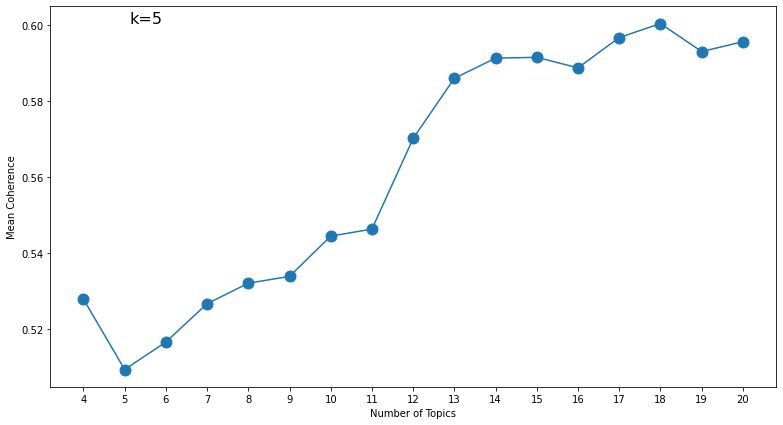

In [26]:
fig = plt.figure(figsize=(13,7))
# create the line plot
ax = plt.plot( k_values, coherences )
plt.xticks(k_values)
plt.xlabel("Number of Topics")
plt.ylabel("Mean Coherence")
# add the points
plt.scatter(k_values, coherences, s=120)
# find and annotate the maximum point on the plot
ymin = min(coherences)
ymax = max(coherences)
xpos = coherences.index(ymin)
#best_k = k_values[xpos]
best_k_c = k_values[1] #manually set the best k value
plt.annotate("k=%d" % best_k_c, xy=(best_k_c, ymax), xytext=(best_k_c, ymax), textcoords="offset points", fontsize=16)
# show the plot
plt.show()

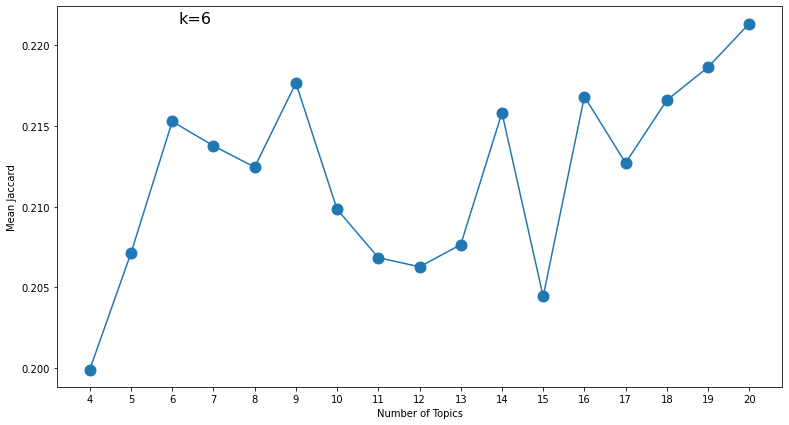

In [27]:
fig = plt.figure(figsize=(13,7))
# create the line plot
ax = plt.plot( k_values, jaccards )
plt.xticks(k_values)
plt.xlabel("Number of Topics")
plt.ylabel("Mean Jaccard")
# add the points
plt.scatter(k_values, jaccards, s=120)
# find and annotate the maximum point on the plot
ymin = min(jaccards)
ymax = max(jaccards)
xpos = jaccards.index(ymin)
#best_k = k_values[xpos]
best_k_j = k_values[2] #manually set the best k value
plt.annotate("k=%d" % best_k_j, xy=(best_k_j, ymax), xytext=(best_k_j, ymax), textcoords="offset points", fontsize=16)
# show the plot
plt.show()

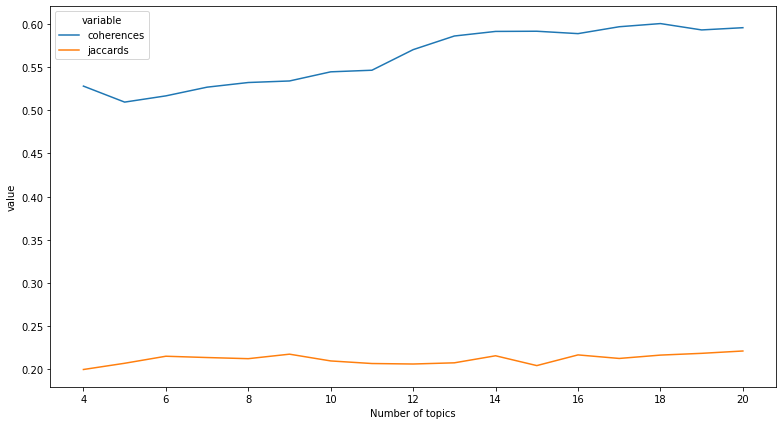

In [28]:
plt.figure(figsize=(13,7))
NMF_sklearn = pd.DataFrame(list(zip(k_values, coherences, jaccards)), 
                  columns = ['num_topics', 'coherences', 'jaccards'])
sns.lineplot(x = 'num_topics',
             y = 'value',
             hue = 'variable',
             data = pd.melt(NMF_sklearn, ['num_topics']))
plt.xlabel('Number of topics')
plt.show()

In [29]:
k = best_k_j
# get the model that we generated earlier.
W = topic_models[k-kmin][1]
H = topic_models[k-kmin][2]

In [30]:
for topic_index in range(k):
    descriptor = get_descriptor(terms, H, topic_index, 10)
    str_descriptor = ", ".join( descriptor )
    print("Topic %02d: %s" % (topic_index+1, str_descriptor) )

Topic 01: guilty, plead, conspiracy, former, price, defraud, executive, conspire, company, employee
Topic 02: tax, return, preparer, federal, shut, file, prepare, false, bar, florida
Topic 03: sentence, prison, month, child, former, pornography, conspiracy, virginia, life, member
Topic 04: pay, claim, million, false, allegation, resolve, settle, agree, discrimination, company
Topic 05: charge, former, officer, right, civil, police, federal, indict, statement, new
Topic 06: fraud, scheme, million, health, role, medicare, care, owner, area, miami


## BTM

In [31]:
titles['lemma_clean'] = [' '.join(map(str, l)) for l in titles['tokens']]

In [32]:
texts = titles['lemma_clean'].str.strip().tolist()

In [33]:
# PREPROCESSING
# Obtaining terms frequency in a sparse matrix and corpus vocabulary
X, vocabulary, vocab_dict = btm.get_words_freqs(texts)
tf = np.array(X.sum(axis=0)).ravel()
# Vectorizing documents
docs_vec = btm.get_vectorized_docs(texts, vocabulary)
docs_lens = list(map(len, docs_vec))
# Generating biterms
biterms = btm.get_biterms(docs_vec)

In [35]:
# INITIALIZING AND RUNNING MODEL
model = btm.BTM(
    X, vocabulary, seed=12321, T=10, M=10, alpha=50/8, beta=0.01)
model.fit(biterms, iterations=50)
p_zd = model.transform(docs_vec)

100%|█████████████████████████████████| 17824/17824 [00:00<00:00, 355188.07it/s]


In [36]:
# METRICS
perplexity = btm.perplexity(model.matrix_topics_words_, p_zd, X, 8)
coherence = btm.coherence(model.matrix_topics_words_, X, M=10)

In [37]:
coherence

array([-174.97048623,  -75.99058968, -119.74139943, -109.24316555,
       -121.29675418, -130.3374783 , -126.82569906,  -94.20759006,
        -87.45378623, -136.33207948])

In [38]:
top_words = btm.get_top_topic_words(
    model,
    words_num=10)

In [39]:
top_words

,topic0,topic1,topic2,topic3,topic4,topic5,topic6,topic7,topic8,topic9
0,announce,pay,charge,guilty,sentence,former,lawsuit,tax,fraud,remark
1,million,million,sentence,plead,prison,guilty,discrimination,return,scheme,statement
2,settlement,claim,member,former,guilty,plead,file,sentence,million,deliver
3,reach,false,prison,company,child,sentence,county,preparer,guilty,announce
4,bank,resolve,guilty,agree,plead,officer,agreement,federal,plead,deputy
5,program,allegation,conspiracy,executive,scheme,charge,settle,guilty,sentence,national
6,require,settle,plead,conspiracy,charge,prison,reach,plead,health,holder
7,order,agree,crime,price,pornography,right,right,fraud,role,barr
8,agreement,company,murder,pay,company,civil,disability,false,owner,william
9,acquisition,relate,federal,million,former,support,settlement,prison,prison,conference


In [113]:
coherences

[31.191623125197538,
 31.191623125197538,
 31.191623125197538,
 31.191623125197538,
 31.191623125197538,
 31.19162312519754,
 31.191623125197545,
 31.191623125197545,
 31.191623125197548,
 31.191623125197548,
 31.191623125197548,
 31.19162312519755,
 31.19162312519755,
 31.19162312519755,
 31.19162312519755,
 31.191623125197555,
 31.191623125197555]

In [98]:
top_docs = btm.get_top_topic_docs(
    texts,
    p_zd,
    docs_num=10)

In [99]:
top_docs

,topic0,topic1,topic2,topic3,topic4,topic5,topic6,topic7
0,statement spokesperson kerri kupec execution c...,chevron pay million resolve allegation false c...,latin dragon gang member charge murder aid rac...,yevgeniy nikulin indict hack linkedin dropbox ...,diecisiete supuestos jefes asociado del clan u...,announce resolution npb neue privat bank ag,barr holiday message,sue permanently enjoinflorida tax return preparer
1,statement spokesperson kerri kupec execution k...,arete sleep pay resolve false claim allegation,almighty imperial gangster member convict murd...,rbs securities japan ltd sentence manipulation...,jamshid muhtorov bakhtiyor jumaev guilty provi...,appoints gary grindler deputy,fy budget request,shut georgia return preparer
2,issue memo marijuana,settle discrimination claim aerojet rocketdyne...,ms highest rank leader charge terrorism offense,amazon marketplace seller plead guilty price f...,el departamento de justicia llega un acuerdo c...,reach settlement anheuser busch inbev grupo mo...,fy budget request,shut alabama tax return preparer
3,statement spokesperson kerri kupec execution l...,interface rehab pay million resolve false clai...,gangster disciple member indict tennessee murder,future trader charge illegally manipulate stoc...,norridgewock sentence child exploitation porno...,hypothekarbank lenzburg ag reach resolution sw...,fy budget request,bar florida tax return preparer prepare return
4,statement christopher wray,boehringer ingelheim pay million resolve false...,member associate barrio azteca gang charge rac...,three former rabobank trader charge manipulate...,terrorist sentence provide material support al...,finter bank zurich ag reach resolution swiss b...,fy budget request,shut maryland return preparer
5,statement spokesperson kerri kupec execution w...,bolling shipyard agree settle false claim suit,member associate violent gang indict,former rabobank libor submitter plead guilty s...,iraqi refugee sentence attempt provide materia...,bank eki genossenschaft reach resolution swiss...,fy budget request,permanently enjoin georgia tax return preparer
6,deere abandon propose acquisition precision pl...,accenture pay million settle false claim alleg...,nine member violent outlaw motorcycle gang arrest,two former rabobank trader convict manipulate ...,patient recruiter physical therapist sentence ...,vadian bank ag reach resolution swiss bank pro...,fy budget request,shut idaho tax return preparer
7,block aetna acquisition humana,caremark pay million resolve false claim alleg...,member associate tennessee mongols motorcycle ...,deutsche bank london subsidiary sentence manip...,citizen sentence provide material support al s...,valiant bank ag reach resolution swiss bank pr...,fy budget request,bar florida tax preparer prepare return
8,flakeboard abandon propose acquisition sierrapine,saic pay million resolve false claim allegation,allege associate la cosa nostra charge extorti...,former rabobank derivative trader plead guilty...,alaskan convict sexually exploit child cambodia,announce resolution llb verwaltung switzerland ag,fy budget request,shut illinois tax return preparer
9,transition begin,testech ceso agree pay million resolve false c...,wildboy gang member convict violent crime aid ...,supplement retailer plead guilty involve distr...,houston area patient recruiter convict health ...,swiss bank reach resolution swiss bank program,fy budget request,federal permanently bar stratham nh tax prepar...


In [100]:
top_words = btm.get_top_topic_words(
    model,
    words_num=10)

In [101]:
top_words

,topic0,topic1,topic2,topic3,topic4,topic5,topic6,topic7
0,announce,pay,charge,guilty,fraud,bank,remark,tax
1,statement,million,former,plead,sentence,former,lawsuit,return
2,antitrust,claim,sentence,scheme,scheme,national,deliver,guilty
3,crime,resolve,guilty,former,prison,million,announce,plead
4,federal,false,plead,fraud,guilty,charge,new,fraud
5,national,settle,officer,sentence,plead,guilty,statement,sentence
6,holder,allegation,member,company,million,plead,agreement,preparer
7,price,agree,prison,conspiracy,health,program,file,federal
8,order,company,federal,charge,role,reach,county,prison
9,agree,discrimination,conspiracy,million,medicare,announce,deputy,file


## BTM pt. 2

In [103]:
text = " ".join(review for review in titles.lemma_clean)

vec = CountVectorizer()
X = vec.fit_transform([text])

In [104]:
from biterm.utility import vec_to_biterms
vocab = np.array(vec.get_feature_names_out())
biterms = vec_to_biterms(X)

In [106]:
from biterm.cbtm import oBTM

btm = oBTM(num_topics=15, V=vocab)
topics = btm.fit_transform(biterms, iterations=2)

/var/folders/fm/xwcj8f4d2xl395kr3dnsf8z40000gn/T/ipykernel_54435/2860737770.py:4: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  topics = btm.fit_transform(biterms, iterations=2)
/var/folders/fm/xwcj8f4d2xl395kr3dnsf8z40000gn/T/ipykernel_54435/2860737770.py:4: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to rev

KeyboardInterrupt: 

In [ ]:
topic_summuary(btm.phi_wz.T, X, vocab, 10)